In [4]:
import jax
import jax.numpy as jnp
import numpy as np

from jax import grad, jit, vmap, pmap
from jax import random

import matplotlib.pyplot as plt

from copy import deepcopy
from typing import Tuple, NamedTuple
import functools

## The Problem of State

JAX are Pure Functions => JAX doesn't track states

Any tree-like structure built out of container-like Python objects can be referred to as pytrees in JAX. Classes are considered container-like if they are in the pytree registry, which by default includes lists, tuples, and dicts. Any object whose type is not in the pytree container registry will be treated as a leaf node in the tree.

The pytree registry can be extended to include user-defined container classes by registering a pair of functions that specify:

1. How to convert an instance of the container type to a (children, metadata) pair; and

2. How to convert this pair back to an instance of the container type.

JAX will use these functions to canonicalize any tree of registered container objects into a flat tuple, and then reassemble the tree-like container before returning the processed data to the user.

In [5]:
## Let's now explicitly address and understand the problem of state!
# Why?
# Well, NNs love statefulness: model params, optimizer params, BatchNorm etc
# and we've seen that JAX seems to have a problem with it.

class Counter:
  """A simple counter."""

  def __init__(self):
    self.n = 0

  def count(self) -> int:
    self.n += 1
    return self.n

  def reset(self):
    self.n = 0


counter = Counter()

for _ in range(3):
  print(counter.count())

1
2
3


In [6]:
counter.reset()

fast_count = jax.jit(counter.count)

for _ in range(3): ## oops, it's not working as it's supposed to be
  print(fast_count())

1
1
1


In [7]:
from jax import make_jaxpr

counter.reset()

print(make_jaxpr(counter.count)())

{ lambda ; . let  in (1,) }


In [8]:
CounterState = int


class CounterV2:

  def count(self, n: CounterState) -> Tuple[int, CounterState]:
    # You could just return n+1, but here we separate its rol as the output
    # and as the counter state for didactic purposes.
    # (As the output may be some arbitrary function of state in general case)

    return n+1, n+1


  def reset(self) -> CounterState:
    return 0


counter = CounterV2()
state = counter.reset()

for _ in range(3):
  value, state = counter.count(state) # looks familiar?
  print(value)

1
2
3


In [9]:
state = counter.reset()

fast_count = jax.jit(counter.count)

for _ in range(3):
  value, state = fast_count(state)
  print(value)

1
2
3


## In summary we used the following rule to convert a stateful class:

### Statefull
```python3
class StatefulClass

  state: State

  def stateful_method(state: State, *args, **kwargs) -> Output:

```

### Stateless
```python3
class StatelessClass

  def stateless_metho(state: State, *args, **kwargs) -> (Ouput, State):
```

##PyTree

In [10]:
f = lambda x, y, z, w: x**2 + y**2 + z**2 + w**2

# JAX: .backward() is not that great
# also JAX:
x, y, z, w = [1.] * 4
dfdx, dfdy, dfdz, dfdw = grad(f, argnums=(0, 1, 2, 3))(x, y, z, w)
print(dfdx, dfdy, dfdz, dfdw)


# Great now we just need to update our params!
# lr = 0.001
# x -= lr*dfdx
# y -= lr&dfdy
# ...(175B lines later)
# w -= lr*dfdw

# No, no, no
# we do have a better way.

2.0 2.0 2.0 2.0


### jax knows how to deal with these! The answer is called a PyTree.

In [11]:
pytree_example = [
     [1, 'a', object()],
     (1, (2, 3), ()),
     [1, {'k1': 2, 'k2': (3, 4)}, 5],
      {'a': 2, 'b':(2, 3)},
     jnp.array([1, 2, 3]),

]

for pytree in pytree_example:
  leaves = jax.tree_leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x79531d552d80>]   has 3 leaves: [1, 'a', <object object at 0x79531d552d80>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
DeviceArray([1, 2, 3], dtype=int32)           has 1 leaves: [DeviceArray([1, 2, 3], dtype=int32)]


<ipython-input-11-a261b55f84d5>:11: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  leaves = jax.tree_leaves(pytree)


In [12]:
def init_mlp_params(layer_widths):
  params = []

  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,)))
    )

  return params

params = init_mlp_params([1, 128, 128, 1])

jax.tree_map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [13]:
def forward(params, x):
  *hidden, last = params

  for layer in hidden:
    x = jax.nn.relu(jnp.dot(x, layer['weights']) + layer['biases'])

  return jnp.dot(x, last['weights']) + last['biases']

def loss_fn(params, x, y):
  return jnp.mean((forward(params, x) - y)**2) # MSE Loss


lr = 0.0001

@jit
def update(params, x, y):

  # Note that grads is a pytree with the same structure as params.
  # grad is one of the many JAX functions that has built-in support for pytrees!
  grads = jax.grad(loss_fn)(params, x, y)

  # SGD update
  return jax.tree_map(
      lambda p, g: p - lr * g, params, grads)

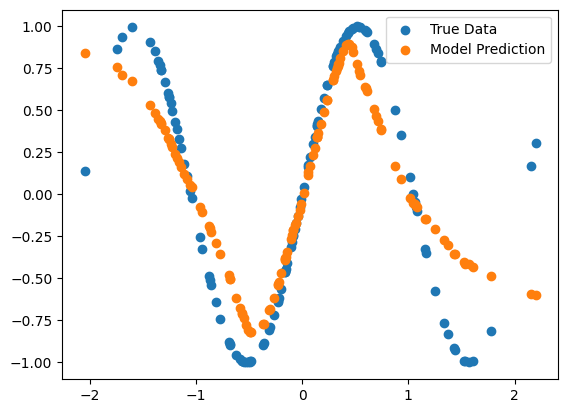

In [14]:
xs = np.random.normal(size=(128, 1))

ys = np.sin(3*xs)

num_epochs = 5000

for _ in range(num_epochs):
  params = update(params, xs, ys)

plt.scatter(xs, ys, label="True Data")
plt.scatter(xs, forward(params, xs), label='Model Prediction')
plt.legend()
plt.show()

## Custom PyTrees

[Documentation](https://jax.readthedocs.io/en/latest/tutorials/working-with-pytrees.html#common-function-jax-tree-map)

In [15]:
class Special(object):
  def __init__(self, x, y):
    self.x = x
    self.y = y

jax.tree_util.tree_leaves([
    Special(0, 1),
    Special(2, 4),
])

[<__main__.Special at 0x7952ea579e10>, <__main__.Special at 0x7952ea57a860>]

In [16]:
from jax.tree_util import register_pytree_node

class RegisteredSpecial(Special):
  def __repr__(self):
    return "RegisteredSpecial(x={}, y={})".format(self.x, self.y)

def special_flatten(v):
  """Specifies a flattening recipe.

  Params:
    v: The value of the registered type to flatten.
  Returns:
    A pair of an iterable with the children to be flattened recursively,
    and some opaque auxiliary data to pass back to the unflattening recipe.
    The auxiliary data is stored in the treedef for use during unflattening.
    The auxiliary data could be used, for example, for dictionary keys.
  """
  children = (v.x, v.y)
  aux_data = None
  return (children, aux_data)

def special_unflatten(aux_data, children):
  """Specifies an unflattening recipe.

  Params:
    aux_data: The opaque data that was specified during flattening of the
      current tree definition.
    children: The unflattened children

  Returns:
    A reconstructed object of the registered type, using the specified
    children and auxiliary data.
  """
  return RegisteredSpecial(*children)

# Global registration
register_pytree_node(
    RegisteredSpecial,
    special_flatten,    # Instruct JAX what are the children nodes.
    special_unflatten   # Instruct JAX how to pack back into a `RegisteredSpecial`.
)

In [17]:
jax.tree_map(lambda x: x + 1,
[
  RegisteredSpecial(0, 1),
  RegisteredSpecial(2, 4),
])

[RegisteredSpecial(x=1, y=2), RegisteredSpecial(x=3, y=5)]

In [18]:
from typing import NamedTuple, Any

class MyOtherContainer(NamedTuple):
  name: str
  a: Any
  b: Any
  c: Any

# NamedTuple subclasses are handled as pytree nodes, so
# this will work out-of-the-box.
jax.tree_util.tree_leaves([
    MyOtherContainer('Alice', 1, 2, 3),
    MyOtherContainer('Bob', 4, 5, 6)
])

['Alice', 1, 2, 3, 'Bob', 4, 5, 6]

## Parallelism in JAX

Parallelism in JAX is handled by another function `pmap`

In [19]:
x = np.arange(5)
w = np.array([2., 3., 4.])


def convolve(w, x): # Implement of 1D covolution/correlation
  output = []

  for i in range(1, len(x) - 1):
    output.append(jnp.dot(x[i-1:i+2], w))

  return jnp.array(output)


result = convolve(w, x)
print(repr(result))

DeviceArray([11., 20., 29.], dtype=float32)


In [20]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

import jax
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
jax.devices()

tpu


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [21]:
n_devices = jax.local_device_count()
print(f"Number of available devices: {n_devices}")

xs = np.arange(5 * n_devices).reshape(-1, 5)
ws = np.stack([w] * n_devices)

print(xs.shape, ws.shape)

Number of available devices: 8
(8, 5) (8, 3)


In [22]:
# First way to optimizer this is to simpy use vmap

vmap_result = jax.vmap(convolve)(ws, xs)
print(repr(vmap_result))

DeviceArray([[ 11.,  20.,  29.],
             [ 56.,  65.,  74.],
             [101., 110., 119.],
             [146., 155., 164.],
             [191., 200., 209.],
             [236., 245., 254.],
             [281., 290., 299.],
             [326., 335., 344.]], dtype=float32)


In [23]:
# The amazing this is if you just swap vmap for pmap you are not running on multiple
# devices. How cool is that?

pmap_result = jax.pmap(convolve)(ws, xs)
print(repr(pmap_result))

ShardedDeviceArray([[ 11.,  20.,  29.],
                    [ 56.,  65.,  74.],
                    [101., 110., 119.],
                    [146., 155., 164.],
                    [191., 200., 209.],
                    [236., 245., 254.],
                    [281., 290., 299.],
                    [326., 335., 344.]], dtype=float32)


In [24]:
double_pmap_result = jax.pmap(convolve)(jax.pmap(convolve)(ws, xs), xs)
print(repr(double_pmap_result))

ShardedDeviceArray([[   78.,   138.,   198.],
                    [ 1188.,  1383.,  1578.],
                    [ 3648.,  3978.,  4308.],
                    [ 7458.,  7923.,  8388.],
                    [12618., 13218., 13818.],
                    [19128., 19863., 20598.],
                    [26988., 27858., 28728.],
                    [36198., 37203., 38208.]], dtype=float32)


In [25]:
pmap_smarter_result = jax.pmap(convolve, in_axes=(None, 0))(w, xs)
print(repr(pmap_smarter_result))

ShardedDeviceArray([[ 11.,  20.,  29.],
                    [ 56.,  65.,  74.],
                    [101., 110., 119.],
                    [146., 155., 164.],
                    [191., 200., 209.],
                    [236., 245., 254.],
                    [281., 290., 299.],
                    [326., 335., 344.]], dtype=float32)


## Communication between devices

In [26]:
def normalized_convolution(w, x):
  output = []

  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))

  output = jnp.array(output)

  return output / jax.lax.psum(output, axis_name='batch_dim') # this is where communication happens


res_pmap = jax.pmap(normalized_convolution, axis_name='batch_dim', in_axes=(None, 0))(w, xs)
res_vmap = jax.vmap(normalized_convolution, axis_name='batch_dim', in_axes=(None, 0))(w, xs)

print(repr(res_pmap))
print(repr(res_vmap))

print(f"Verify the output is normalized: {sum(res_pmap[:, 0])}")

ShardedDeviceArray([[0.00816024, 0.01408451, 0.019437  ],
                    [0.04154303, 0.04577465, 0.04959785],
                    [0.07492582, 0.07746479, 0.07975871],
                    [0.10830861, 0.10915492, 0.10991956],
                    [0.14169139, 0.14084506, 0.14008042],
                    [0.17507419, 0.17253521, 0.17024128],
                    [0.20845698, 0.20422535, 0.20040214],
                    [0.24183977, 0.23591548, 0.23056298]], dtype=float32)
DeviceArray([[0.00816024, 0.01408451, 0.019437  ],
             [0.04154303, 0.04577465, 0.04959785],
             [0.07492582, 0.07746479, 0.07975871],
             [0.10830861, 0.10915492, 0.10991956],
             [0.14169139, 0.14084506, 0.14008042],
             [0.17507419, 0.17253521, 0.17024128],
             [0.20845698, 0.20422535, 0.20040214],
             [0.24183977, 0.23591548, 0.23056298]], dtype=float32)
Verify the output is normalized: 1.0


In [28]:
# We also needs loss value aside from grads

def sum_squared_error(x, y):
  return sum((x-y)**2)


x = jnp.arange(4, dtype=jnp.float32)
y = x + 0.1

print(x)
print(y)

jax.value_and_grad(sum_squared_error)(x, y)

[0. 1. 2. 3.]
[0.1 1.1 2.1 3.1]


(DeviceArray(0.03999997, dtype=float32),
 DeviceArray([-0.2       , -0.20000005, -0.19999981, -0.19999981], dtype=float32))

In [29]:
## And sometimes the loss function needs to return intermediate results

def sum_squared_error_with_aux(x, y):
  return sum((x-y)**2), x-y

jax.grad(sum_squared_error_with_aux, has_aux=True)(x, y) # has_aux=True

(DeviceArray([-0.2       , -0.20000005, -0.19999981, -0.19999981], dtype=float32),
 DeviceArray([-0.1       , -0.10000002, -0.0999999 , -0.0999999 ], dtype=float32))

## Traiin ML model in Parallel

In [49]:
class Params(NamedTuple):
  weight: jnp.ndarray
  bias: jnp.ndarray

lr = 0.005

def init_model(rng):
  weights_key, bias_key = jax.random.split(rng)
  weight = jax.random.normal(weights_key, ())
  bias = jax.random.normal(bias_key, ())
  return Params(weight, bias)


def forward(params, x):
  return params.weight * x + params.bias


def loss_fn(params, xs, ys):
  pred = forward(params, xs)
  return jnp.mean((pred - ys)**2) # MSE

@functools.partial(jax.pmap, axis_name='batch')
def update(params, xs, ys):

  # Compute the gradients on the given minibatch (individuall on each device)
  loss, grads = jax.value_and_grad(loss_fn)(params, xs, ys)

  # Combine the gradient across all devices (by taking their mean).
  grads = jax.lax.pmean(grads, axis_name='batch')

  # Also combine the loss. Unncessary for the update, but useful for logging.
  loss = jax.lax.pmean(loss, axis_name='batch')

  # Each device performs its own SGD update, but since we start with the same
  # params and synchronise gradients, the params stay in sync on each device
  new_params = jax.tree_map(
      lambda param, g: param - g * lr, params, grads
  )

  # if we were using adam or another stateful optimizers
  # we would also do something like:
  # updates, new_optimizer_state = optimizer(grads, optimizer_state)
  # and then use updates insteas of grads to actually update the params.

  return new_params, loss


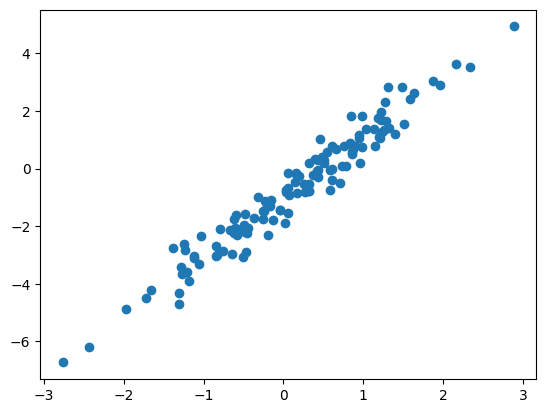

In [46]:
# Generate true data from y = w * x + b + noise

true_w, true_b = 2, -1

xs = np.random.normal(size=(128, 1))
noise = 0.5 * np.random.normal(size=(128, 1))

ys = xs * true_w + true_b + noise


plt.scatter(xs, ys)

plt.show()

In [50]:
# Initialize paramters and replicate across devices.

params = init_model(jax.random.PRNGKey(0))
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)

print(replicated_params)


# Prepare the data
def reshape_for_pmap(data, n_devices):
  return data.reshape(n_devices, data.shape[0] // n_devices, *data.shape[1:])


x_parallel = reshape_for_pmap(xs, n_devices)
y_parallel = reshape_for_pmap(ys, n_devices)

print(x_parallel.shape, y_parallel.shape)

Params(weight=DeviceArray([0.14389051, 0.14389051, 0.14389051, 0.14389051, 0.14389051,
             0.14389051, 0.14389051, 0.14389051], dtype=float32), bias=DeviceArray([-1.2515285, -1.2515285, -1.2515285, -1.2515285, -1.2515285,
             -1.2515285, -1.2515285, -1.2515285], dtype=float32))
(8, 16, 1) (8, 16, 1)


In [51]:
def type_after_update(name, obj):
  print(f"after first `update()`, `{name}` is a {type(obj)}")

num_epochs = 1000

for epoch in range(num_epochs):
  # this is where the params and data gets commmunicated to devices
  replicated_params, loss = update(replicated_params, x_parallel, y_parallel)

  # replicated params and loss are now both ShardedDeviceArrays,
  # indicating that they're on the devices
  # x/y_parallel remains a NumpY array on the host (simulating data streaming).

  if epoch == 0:
    type_after_update('replcated_params.weight', replicated_params.weight)
    type_after_update('loss', loss)
    type_after_update('x_parallel', x_parallel)

  if epoch % 100 == 0:
    print(loss.shape)
    print(f"Step {epoch:3d}, loss: {loss[0]:.3f}")


# Like this loss, the leaves of params have an extra leading dimension,
# so we take the params from the first deivce.

params = jax.device_get(jax.tree_map(lambda x: x[0], replicated_params))


after first `update()`, `replcated_params.weight` is a <class 'jax.interpreters.pxla._ShardedDeviceArray'>
after first `update()`, `loss` is a <class 'jax.interpreters.pxla._ShardedDeviceArray'>
after first `update()`, `x_parallel` is a <class 'numpy.ndarray'>
(8,)
Step   0, loss: 4.026
(8,)
Step 100, loss: 0.698
(8,)
Step 200, loss: 0.282
(8,)
Step 300, loss: 0.225
(8,)
Step 400, loss: 0.217
(8,)
Step 500, loss: 0.215
(8,)
Step 600, loss: 0.215
(8,)
Step 700, loss: 0.215
(8,)
Step 800, loss: 0.215
(8,)
Step 900, loss: 0.215


## Auto Diff Cookbook

[link](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html)